<a href="https://colab.research.google.com/github/qn19325/individualProject/blob/main/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
import os
from skimage import io
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [27]:
input_size = 4096 # size of input image
hidden_size = 128 
num_classes = 11
num_epochs = 1
batch_size = 251
learning_rate = 0.001
sequence_length = 251 # two consequitive images
num_layers = 2

In [4]:
class SpeedsAndFramesDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]/10))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

dataset = SpeedsAndFramesDataset(
    csv_file="data.csv",
    root_dir="trainingData",
    transform=transforms.ToTensor(),
)

In [22]:
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

In [8]:
examples = iter(train_loader)
example_data, example_targets = examples.next()

torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])


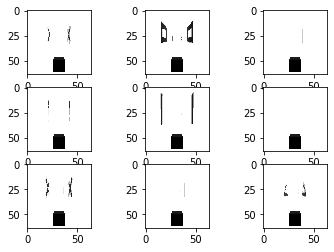

In [12]:
for i in range(9):
    imageNum = random.randint(0,251)
    print(example_data[imageNum][0].shape)
    plt.subplot(3,3,i+1)
    plt.imshow(example_data[imageNum][0], cmap='gray')
plt.show()

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # x -> (batch_size, seq, input_size)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        out = out[:,-1,:]
        out = self.fc(out)
        return out

In [14]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [26]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

RuntimeError: ignored

In [54]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 0.0 %
